In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Exploring
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind, pearsonr

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


from sklearn import *



# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve
%matplotlib inline

import prepare_zillow

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Acquisition, Prep & Initial Exploration


In [2]:
df = prepare_zillow.zillow_csv()
df = prepare_zillow.zillow_ready_to_explore(df)

In [3]:
# Removing outliers 

keys = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet',
                      'structuretaxvaluedollarcnt','landtaxvaluedollarcnt', 'regionidzip', 'regionidcounty']
values = [(1,7), (1,7), (500,8000), (25000,2000000), (10000,2500000), (95000, 99999), (3000,3200)]

dictionary = dict(zip(keys, values))

for key, value in dictionary.items():
    df = df[df[key] >= value[0]]
    df = df[df[key] <= value[1]]

In [4]:
# Dropping columns that don't provide information.

df = df.drop(columns=['id', 
                      'parcelid',
                      'transactiondate',
                      'buildingqualitytypeid', 
                      'propertyzoningdesc', 
                      'regionidcity', 
                      'censustractandblock', 
                      'heatingorsystemdesc',
                      'propertycountylandusecode',
                      'rawcensustractandblock',
                      'assessmentyear',
                      'roomcnt',
                      'unitcnt',
                      'Unnamed: 0'])


# Only a few NaN left, dropping.
df.dropna(inplace=True)


# bathroomcnt, calculatedbathnbr and fullbathcnt are all the same numbers
# calculatedfinishedsquarefeet and finishedsquarefeet12 same
df = df.drop(columns=['calculatedbathnbr', 'fullbathcnt', 'finishedsquarefeet12', 'regionidcounty', 'fips'])


In [5]:
float_num = ['bathroomcnt', 
             'bedroomcnt', 
             'latitude', 
             'longitude', 
             'regionidzip', 
             'yearbuilt']

def float_to_int(df: pd.DataFrame, cols: tuple) -> pd.DataFrame:
    to_coerce = {col: 'int' for col in cols}
    return df.astype(to_coerce)

df = float_to_int(df, float_num)


In [6]:
# landuse_encoded 0 = Condominium and 1 = Single Family Residential

le = LabelEncoder()
le.fit(df.propertylandusedesc)
df['landuse_encoded'] = le.transform(df.propertylandusedesc)

df.drop(columns=['propertylandusedesc'], inplace=True)

In [7]:
df_mod = df.copy()

In [8]:
df_mod = df_mod[df_mod['landuse_encoded'] == 1]
df_mod.drop(columns=['landuse_encoded'], inplace= True)

In [9]:
df_mod.drop(columns=['taxamount'], inplace=True)

### Feature Engineering

In [10]:
df_mod['bednbath'] = df.bedroomcnt + df.bathroomcnt
df_mod.drop(columns=['bathroomcnt', 'bedroomcnt'], inplace=True)

In [11]:
df_mod['price_per_sqft_structure'] = df_mod.structuretaxvaluedollarcnt / df_mod.calculatedfinishedsquarefeet
df_mod.drop(columns=['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet'], inplace=True)

In [12]:
df_mod['price_per_sqft_land'] = df_mod.landtaxvaluedollarcnt / df_mod.lotsizesquarefeet
df_mod.drop(columns=['landtaxvaluedollarcnt', 'lotsizesquarefeet'], inplace=True)

In [13]:
df_mod['age'] = 2019 - df.yearbuilt
df_mod.drop(columns=['yearbuilt'], inplace=True)


In [14]:
df_mod['log_bin'] = pd.qcut(df_mod.logerror, 4, labels=False)

In [15]:
df_mod['age_bin'] = pd.qcut(df_mod.age, 10, labels=False)

In [16]:
scaler = MinMaxScaler()
scaler.fit(df_mod[['price_per_sqft_structure']])
df_mod.price_per_sqft_structure = scaler.transform(df_mod[['price_per_sqft_structure']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['price_per_sqft_land']])
df_mod.price_per_sqft_land = scaler.transform(df_mod[['price_per_sqft_land']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['taxvaluedollarcnt']])
df_mod.taxvaluedollarcnt = scaler.transform(df_mod[['taxvaluedollarcnt']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['latitude']])
df_mod.latitude = scaler.transform(df_mod[['latitude']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['longitude']])
df_mod.longitude = scaler.transform(df_mod[['longitude']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['bednbath']])
df_mod.bednbath = scaler.transform(df_mod[['bednbath']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['age']])
df_mod.age = scaler.transform(df_mod[['age']])

scaler = MinMaxScaler()
scaler.fit(df_mod[['regionidzip']])
df_mod.regionidzip = scaler.transform(df_mod[['regionidzip']])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all 

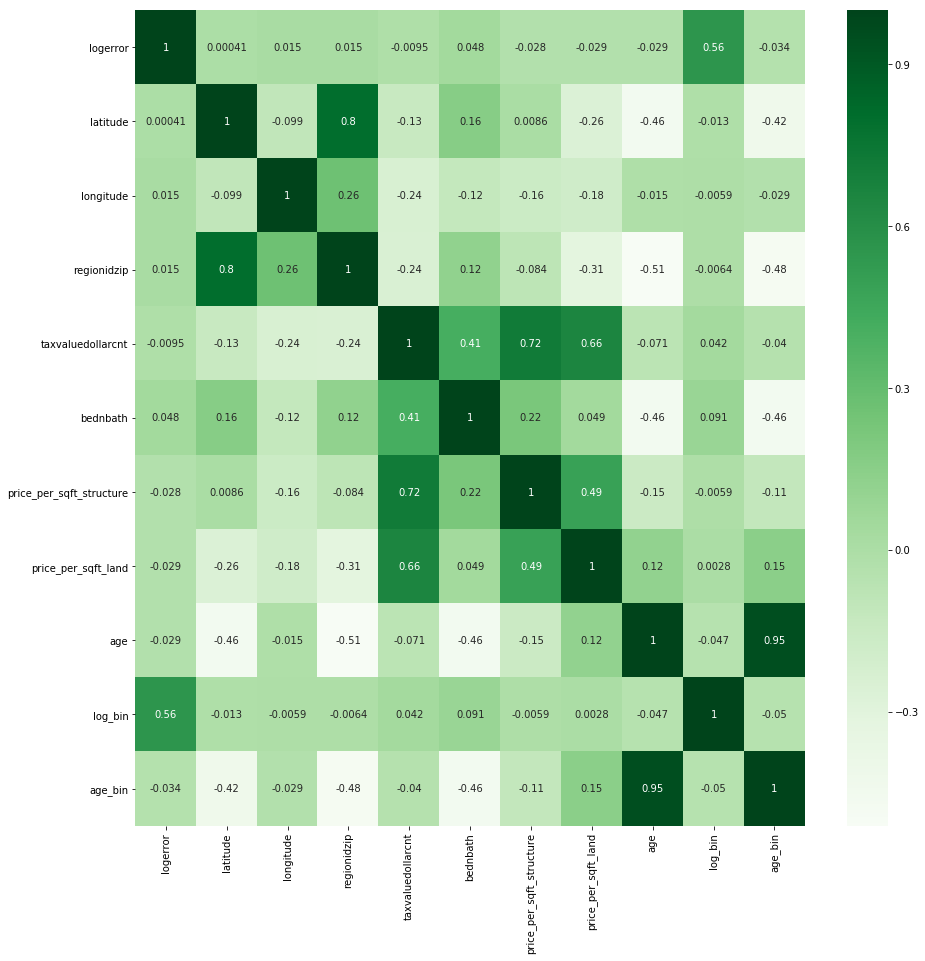

In [17]:
def heatmap_corr(df):
    plt.figure(figsize=(15,15))
    sns.heatmap(df.corr(), cmap='Greens', annot=True)
    
heatmap_corr(df_mod)

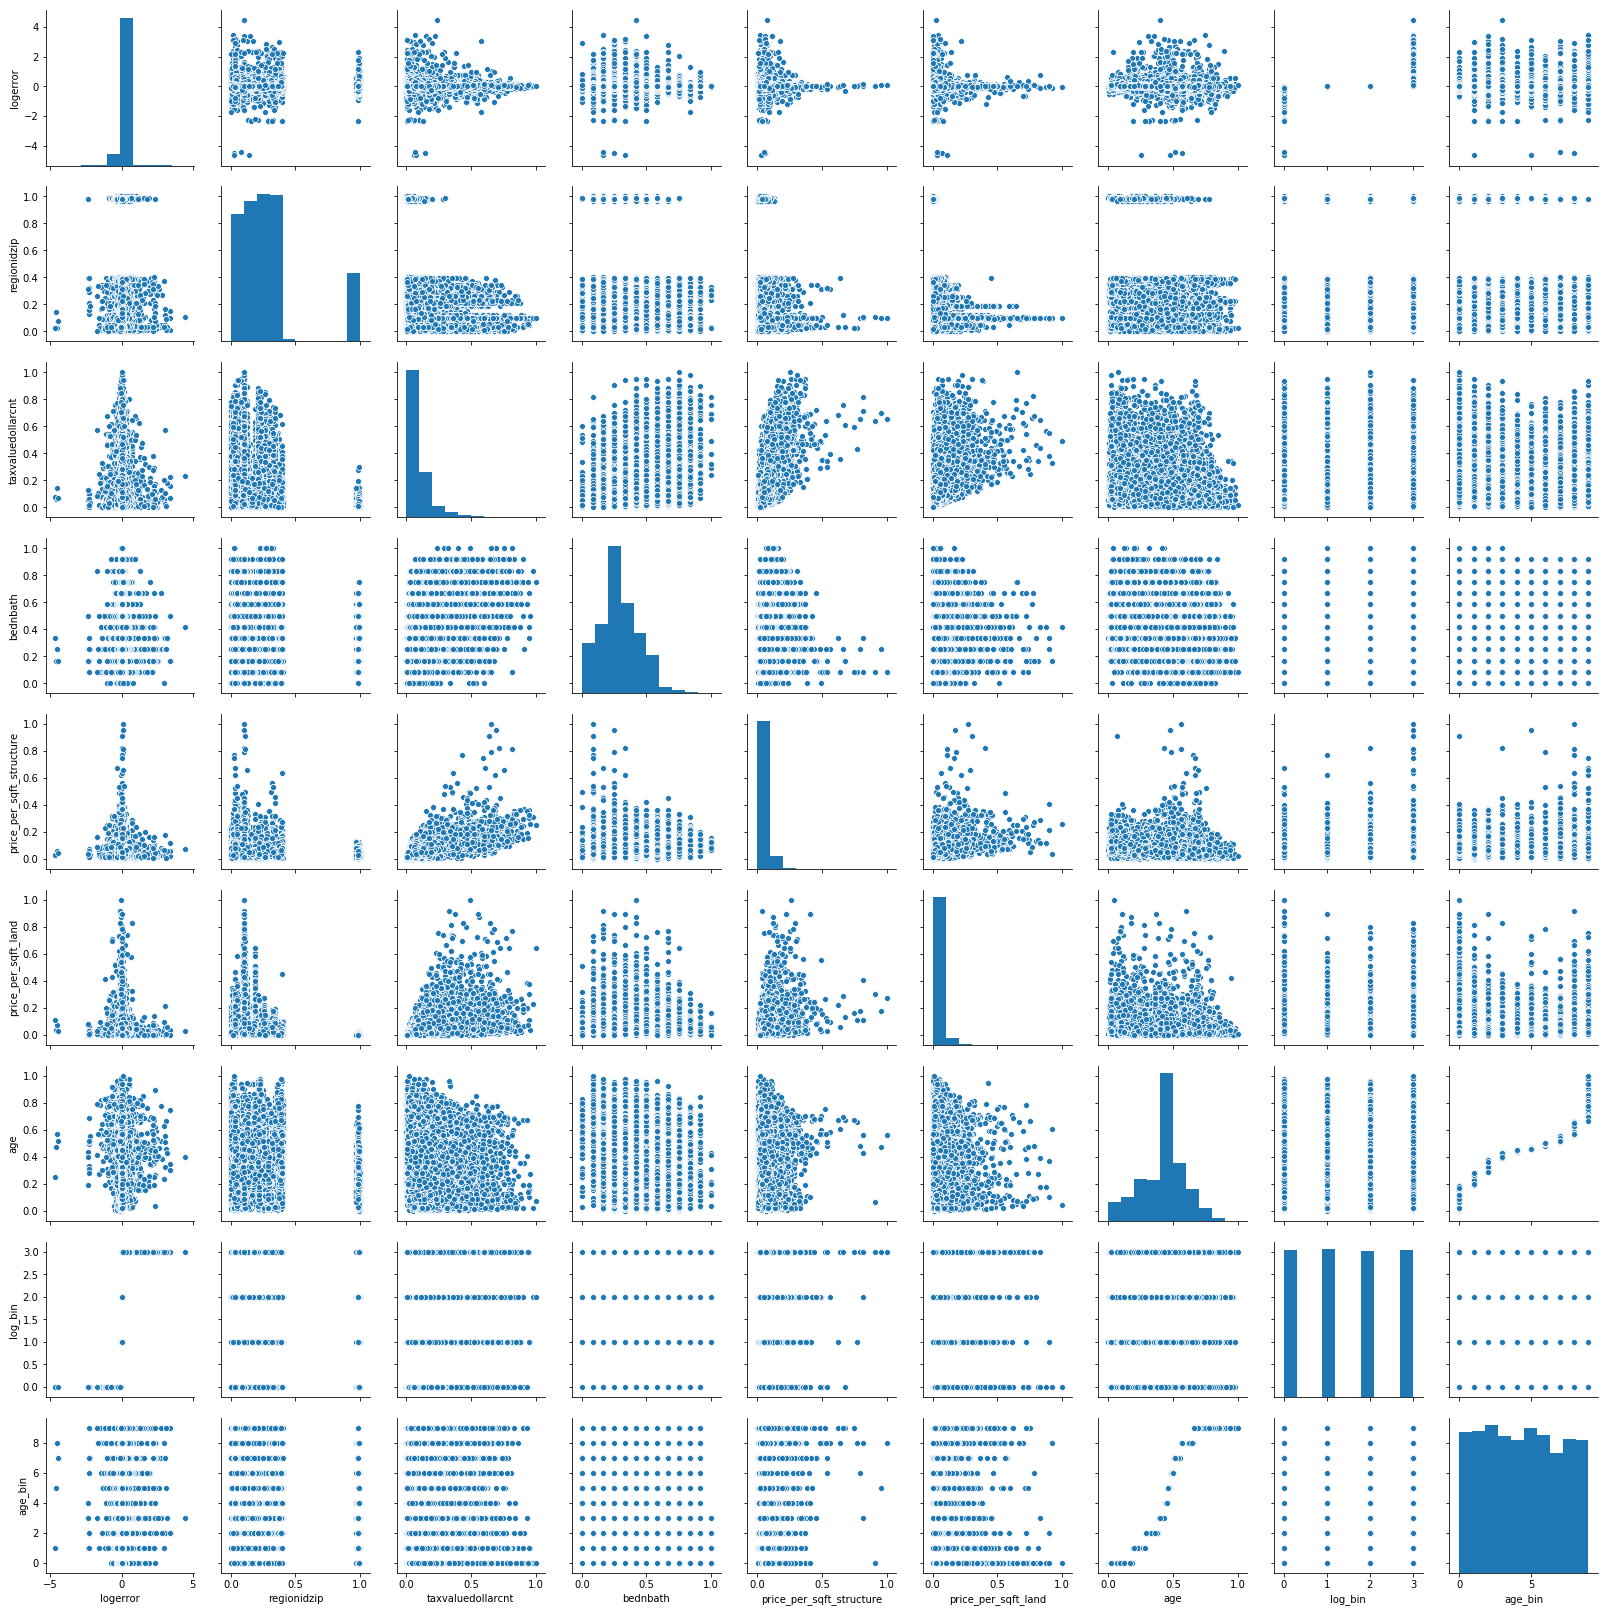

In [18]:
def pairplot_numeric(df):
    sns.pairplot(df.select_dtypes('number').drop(columns=['latitude', 'longitude']))
    
pairplot_numeric(df_mod)

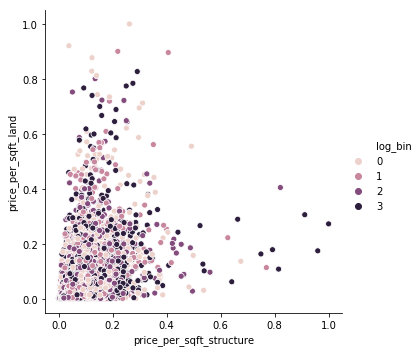

In [19]:
def relpot(df, x, y, hue):
    sns.relplot(data= df, x= x, y= y, hue= hue)

relpot(df_mod, 'price_per_sqft_structure', 'price_per_sqft_land', 'log_bin')

In [20]:
# Write a function that will take, as input, 
# a dataframe, a categorical column name, and a list of numeric column names. 
# It will return a series of subplots: a swarmplot for each numeric column. 
# X will be the categorical variable.

# sns.swarmplot(data= df_mod, x= 'age_bin', y= 'logerror')



# Exploration with Clustering


### Cluster the Target Variable

   k          sse
0  1  1686.531111
1  2  1109.890282
2  3   834.884953
3  4   580.391754
4  5   434.176031
5  6   323.607291
6  7   256.006511
7  8   196.963620
8  9   157.753756


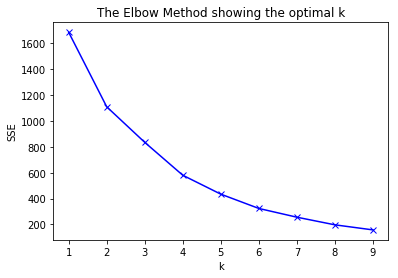

In [21]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['logerror']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [22]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(df_mod[['logerror']])
df_mod['cluster_target'] = kmeans.predict(df_mod[['logerror']])


In [23]:
df_mod.cluster_target.value_counts()

0    50835
3    12571
2     2956
4      320
1      136
Name: cluster_target, dtype: int64

plt.hist(df_mod.cluster_target)

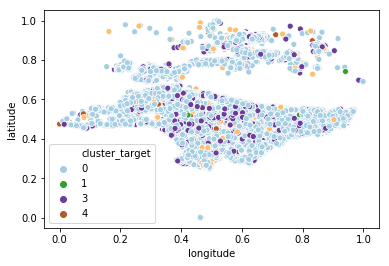

In [24]:
sns.scatterplot(data=df_mod, x='longitude', y= 'latitude', hue= 'cluster_target', palette='Paired')

### Cluster Independent Variables

   k           sse
0  1  14179.233973
1  2   8933.262998
2  3   7204.156934
3  4   6080.843243


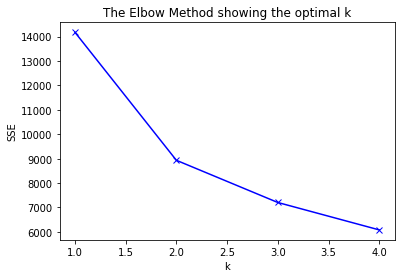

In [25]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['logerror','latitude', 'longitude', 'regionidzip', 
                   'taxvaluedollarcnt', 'bednbath', 'age',
                   'price_per_sqft_structure','price_per_sqft_land']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [26]:
kmeans2 = KMeans(n_clusters=4, random_state=123)

kmeans2.fit(df_mod[['logerror','latitude', 'longitude', 'regionidzip', 
                    'taxvaluedollarcnt', 'bednbath', 'age',
                    'price_per_sqft_structure','price_per_sqft_land']])

df_mod['house_cluster'] = kmeans2.predict(df_mod[['logerror','latitude', 'longitude', 'regionidzip', 
                                                  'taxvaluedollarcnt', 'bednbath', 'age',
                                                  'price_per_sqft_structure','price_per_sqft_land']])

kmeans2.inertia_

6080.8609680593045

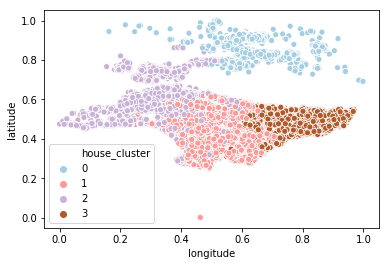

In [27]:
sns.scatterplot(data=df_mod, x='longitude', y= 'latitude', hue= 'house_cluster', palette='Paired')

   k         sse
0  1  696.764983
1  2  257.698917
2  3  130.024182
3  4   77.942414


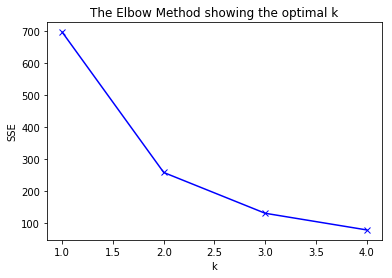

In [28]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['taxvaluedollarcnt']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [29]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['taxvaluedollarcnt']])
df_mod['cluster_tax'] = kmeans.predict(df_mod[['taxvaluedollarcnt']])

   k        sse
0  1  89.393913
1  2  44.674131
2  3  26.119719
3  4  17.300482


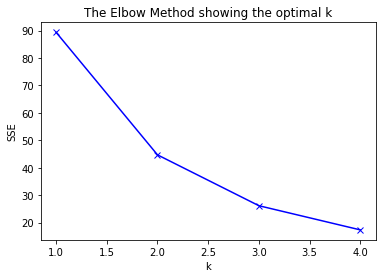

In [30]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['price_per_sqft_structure']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [31]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['price_per_sqft_structure']])
df_mod['cluster_sqft_structure'] = kmeans.predict(df_mod[['price_per_sqft_structure']])

   k         sse
0  1  133.804236
1  2   62.706142
2  3   35.867238
3  4   21.632915


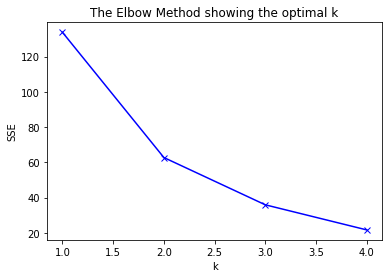

In [32]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['price_per_sqft_land']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['price_per_sqft_land']])
df_mod['cluster_sqft_land'] = kmeans.predict(df_mod[['price_per_sqft_land']])

   k          sse
0  1  1883.765347
1  2   650.832174
2  3   272.311849
3  4   171.356697


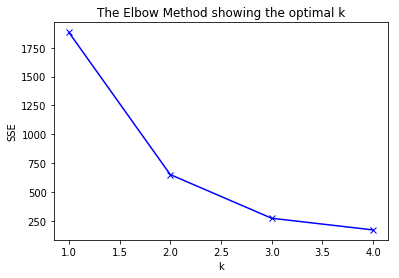

In [34]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['age']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [35]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['age']])
df_mod['cluster_age'] = kmeans.predict(df_mod[['age']])

   k          sse
0  1  4685.621079
1  2   836.093984
2  3   203.711954
3  4    94.313906


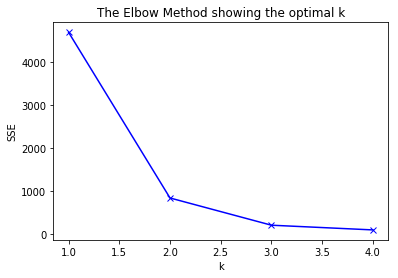

In [36]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['regionidzip']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [37]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['regionidzip']])
df_mod['cluster_zip'] = kmeans.predict(df_mod[['regionidzip']])

   k          sse
0  1  7847.340063
1  2  3634.141697
2  3  2405.777124
3  4  1895.168563


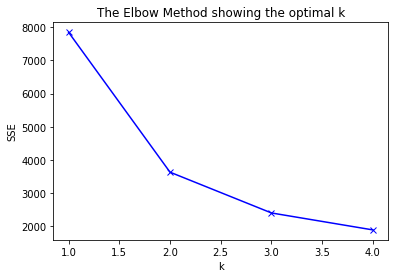

In [38]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['age', 'bednbath', 'regionidzip']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [39]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['age', 'bednbath', 'regionidzip']])
df_mod['cluster_combo'] = kmeans.predict(df_mod[['age', 'bednbath', 'regionidzip']])

   k          sse
0  1  3725.399667
1  2  2182.699737
2  3  1264.793762
3  4   800.325187


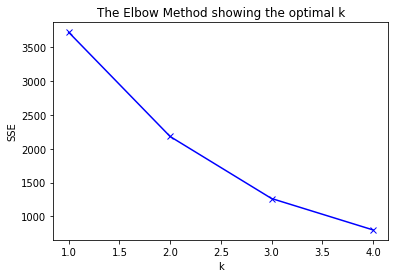

In [40]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['longitude', 'latitude']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['longitude', 'latitude']])
df_mod['cluster_latlong'] = kmeans.predict(df_mod[['longitude', 'latitude']])

   k         sse
0  1  223.198149
1  2  132.858105
2  3   96.769510
3  4   78.439844


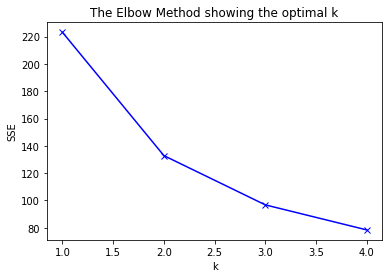

In [42]:
ks = range(1,5)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_mod[['price_per_sqft_land', 'price_per_sqft_structure']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [43]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(df_mod[['price_per_sqft_land', 'price_per_sqft_structure']])
df_mod['cluster_sqft_landstructure'] = kmeans.predict(df_mod[['price_per_sqft_land', 'price_per_sqft_structure']])

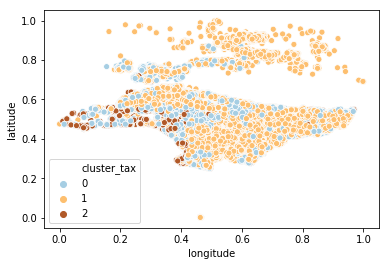

In [44]:
sns.scatterplot(data=df_mod, y='latitude', x='longitude', hue='cluster_tax', palette='Paired')

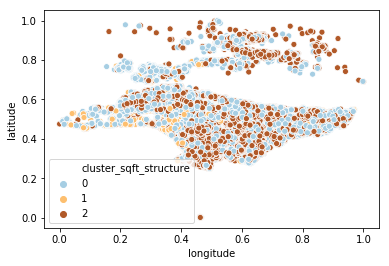

In [45]:
sns.scatterplot(data=df_mod, y='latitude', x='longitude', hue='cluster_sqft_structure', palette='Paired')

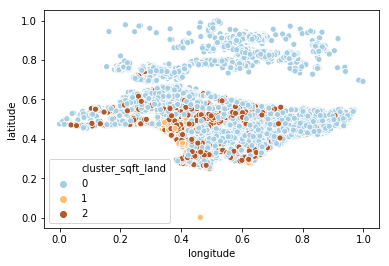

In [46]:
sns.scatterplot(data=df_mod, y='latitude', x='longitude', hue='cluster_sqft_land', palette='Paired')

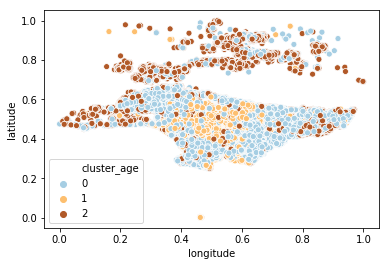

In [47]:
sns.scatterplot(data=df_mod, y='latitude', x='longitude', hue='cluster_age', palette='Paired')

### Test the Significance of Clusters


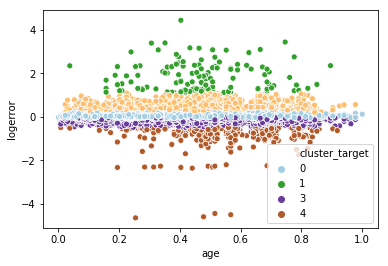

In [48]:
sns.scatterplot(data=df_mod, y='logerror', x='age', hue='cluster_target', palette='Paired')

In [49]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['age'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


2167.0472697615396
2.541147426068708e-199


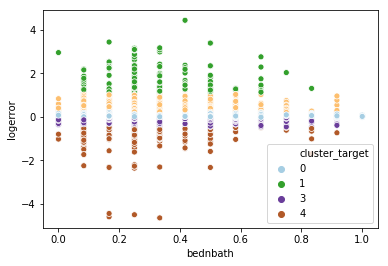

In [50]:
sns.scatterplot(data=df_mod, y='logerror', x='bednbath', hue='cluster_target', palette='Paired')

In [51]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['bednbath'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


732.4232655160179
3.4493657198683885e-123


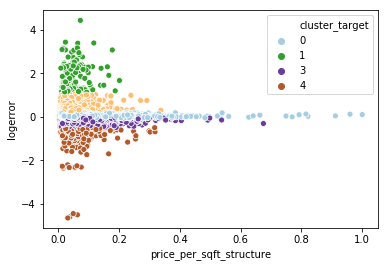

In [52]:
sns.scatterplot(data=df_mod, y='logerror', x='price_per_sqft_structure', hue='cluster_target', palette='Paired')

In [53]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['price_per_sqft_structure'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


264728.5344693946
0.33141118117900353


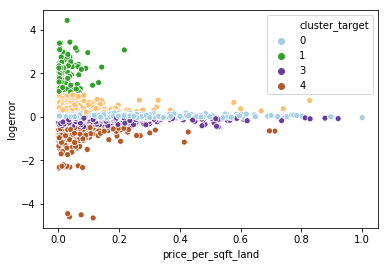

In [54]:
sns.scatterplot(data=df_mod, y='logerror', x='price_per_sqft_land', hue='cluster_target', palette='Paired')

In [55]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['price_per_sqft_land'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


266195.89441784006
0.30669659779746217


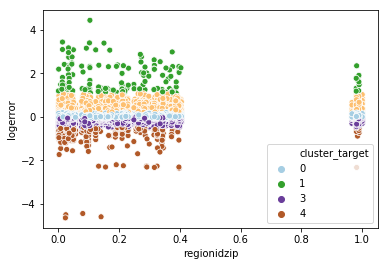

In [56]:
sns.scatterplot(data=df_mod, y='logerror', x='regionidzip', hue='cluster_target', palette='Paired')

In [57]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['regionidzip'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


5461.991190379222
0.0


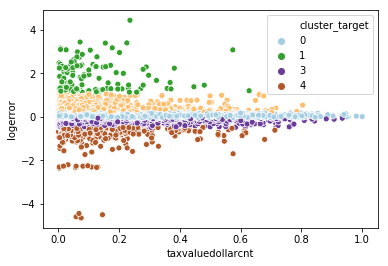

In [58]:
sns.scatterplot(data=df_mod, y='logerror', x='taxvaluedollarcnt', hue='cluster_target', palette='Paired')

In [59]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['taxvaluedollarcnt'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


203804.99399093824
3.234387185917457e-61


In [60]:
tbl = pd.crosstab(df_mod['cluster_target'], df_mod['cluster_combo'])

stat, p, dof, expected = stats.chi2_contingency(tbl)

print(stat)
print(p)


665.3022357589556
2.1047151892152626e-138


In [61]:
pearsonr(df_mod.logerror, df_mod.age)

(-0.029001558635599882, 6.474886245479046e-14)

In [62]:
pearsonr(df_mod.logerror, df_mod.price_per_sqft_structure)

(-0.027826471059596385, 6.284075103459458e-13)

In [63]:
pearsonr(df_mod.logerror, df_mod.regionidzip)

(0.014519143789650732, 0.00017458663063488393)

In [64]:
ttest_ind(df_mod.logerror, df_mod.age_bin)

Ttest_indResult(statistic=-395.7413175369624, pvalue=0.0)

In [65]:
# Dummies?

# zip_dummies = pd.get_dummies(df_mod.cluster_zip)
# df_dummies = df_mod.join(zip_dummies)

# Modeling

In [66]:
# Using the absolute value of logerror to run with regression

df_mod['abs_logerror'] = df_mod.logerror.abs()

In [67]:
# Split test/train

X = df_mod.drop(columns=['logerror', 'abs_logerror', 'log_bin', 'cluster_target'], axis=1)

y = df_mod[['abs_logerror']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.70, random_state=123)


In [68]:
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           abs_logerror   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     686.6
Date:                Mon, 15 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:27:07   Log-Likelihood:                 24109.
No. Observations:               46772   AIC:                        -4.818e+04
Df Residuals:                   46754   BIC:                        -4.803e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
latitude                       0.0139      0.009      1.631      0.103      -0.003       0.031
longitude                     -0.0051      0.007     -0.716      0.474      -0.019       0.009
regionidzip                    0.0022      0.007      0.310      0.756      -0.011       0.016
taxvaluedollarcnt              0.1744      0.013     13.003      0.000       0.148       0.201
bednbath                      -0.0313      0.007     -4.546      0.000      -0.045      -0.018
price_per_sqft_structure      -0.1508      0.030     -5.070      0.000      -0.209      -0.093
price_per_sqft_land           -0.1536      0.023     -6.617      0.000      -0.199      -0.108
age                            0.0933      0.013      6.975      0.000       0.067       0.120
age_bin                        0.0008      0.001      0.979      0.328      -0.001       0.002
house_cluster                  0.0092      0.001      7.348      0.000       0.007       0.012
cluster_tax                   -0.0081      0.002     -5.095      0.000      -0.011      -0.005
cluster_sqft_structure         0.0031      0.001      3.203      0.001       0.001       0.005
cluster_sqft_land             -0.0079      0.001     -6.562      0.000      -0.010      -0.006
cluster_age                    0.0051      0.001      4.813      0.000       0.003       0.007
cluster_zip                    0.0099      0.001      8.227      0.000       0.008       0.012
cluster_combo                 -0.0027      0.001     -2.296      0.022      -0.005      -0.000
cluster_latlong                0.0127      0.002      5.101      0.000       0.008       0.018
cluster_sqft_landstructure     0.0028      0.001      2.465      0.014       0.001       0.005
==============================================================================
Omnibus:                    74634.351   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         67211035.837
Skew:                          10.314   Prob(JB):                         0.00
Kurtosis:                     187.560   Cond. No.                         278.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
ols_model = sm.OLS(y_train, X_train[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                                     'price_per_sqft_land','age','house_cluster','cluster_tax',
                                     'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                                     'cluster_zip','cluster_latlong','cluster_sqft_landstructure']])
fit = ols_model.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           abs_logerror   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     950.1
Date:                Mon, 15 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:27:07   Log-Likelihood:                 24106.
No. Observations:               46772   AIC:                        -4.819e+04
Df Residuals:                   46759   BIC:                        -4.807e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
taxvaluedollarcnt              0.1724      0.013     13.651      0.000       0.148       0.197
bednbath                      -0.0246      0.006     -3.996      0.000      -0.037      -0.013
price_per_sqft_structure      -0.1453      0.028     -5.253      0.000      -0.199      -0.091
price_per_sqft_land           -0.1561      0.023     -6.756      0.000      -0.201      -0.111
age                            0.0998      0.004     25.193      0.000       0.092       0.108
house_cluster                  0.0091      0.001      9.224      0.000       0.007       0.011
cluster_tax                   -0.0080      0.002     -5.128      0.000      -0.011      -0.005
cluster_sqft_structure         0.0030      0.001      3.141      0.002       0.001       0.005
cluster_sqft_land             -0.0080      0.001     -6.754      0.000      -0.010      -0.006
cluster_age                    0.0058      0.001      6.268      0.000       0.004       0.008
cluster_zip                    0.0084      0.001      9.629      0.000       0.007       0.010
cluster_latlong                0.0154      0.001     11.733      0.000       0.013       0.018
cluster_sqft_landstructure     0.0029      0.001      2.543      0.011       0.001       0.005
==============================================================================
Omnibus:                    74630.010   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         67174000.366
Skew:                          10.313   Prob(JB):                         0.00
Kurtosis:                     187.509   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
lm = LinearRegression()
lm.fit(X_train, y_train)
 
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
  
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02088
1.63% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01760
2.16% of the variance in the logerror can be explained by the stuff I selected.


In [71]:
lm = LinearRegression()
lm.fit(X_train[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                'price_per_sqft_land','age','house_cluster','cluster_tax',
                'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                'cluster_zip','cluster_latlong','cluster_sqft_landstructure']], y_train)
 
y_pred_lm = lm.predict(X_train[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                                'price_per_sqft_land','age','house_cluster','cluster_tax',
                                'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                                'cluster_zip','cluster_latlong','cluster_sqft_landstructure']])

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                                    'price_per_sqft_land','age','house_cluster','cluster_tax',
                                    'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                                    'cluster_zip','cluster_latlong','cluster_sqft_landstructure']])
  
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02089
1.61% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01761
2.13% of the variance in the logerror can be explained by the stuff I selected.


In [72]:
lm = LinearRegression(fit_intercept=False, normalize=True)
lm.fit(X_train[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                'price_per_sqft_land','age','house_cluster','cluster_tax',
                'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                'cluster_zip','cluster_latlong','cluster_sqft_landstructure']], y_train)

y_pred_lm = lm.predict(X_train[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                'price_per_sqft_land','age','house_cluster','cluster_tax',
                'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                'cluster_zip','cluster_latlong','cluster_sqft_landstructure']])

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                'price_per_sqft_land','age','house_cluster','cluster_tax',
                'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                'cluster_zip','cluster_latlong','cluster_sqft_landstructure']])

mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02089
1.61% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01761
2.11% of the variance in the logerror can be explained by the stuff I selected.


In [73]:
lm = linear_model.BayesianRidge()
lm.fit(X_train[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                'price_per_sqft_land','age','house_cluster','cluster_tax',
                'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                'cluster_zip','cluster_latlong','cluster_sqft_landstructure']], y_train)
y_pred_lm = lm.predict(X_train[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                'price_per_sqft_land','age','house_cluster','cluster_tax',
                'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                'cluster_zip','cluster_latlong','cluster_sqft_landstructure']])

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test[['taxvaluedollarcnt','bednbath','price_per_sqft_structure',
                'price_per_sqft_land','age','house_cluster','cluster_tax',
                'cluster_sqft_structure','cluster_sqft_land','cluster_age',
                'cluster_zip','cluster_latlong','cluster_sqft_landstructure']])
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02089
1.61% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01760
2.13% of the variance in the logerror can be explained by the stuff I selected.


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [74]:
lm = linear_model.ElasticNet()
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02123
0.00% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01799
-0.00% of the variance in the logerror can be explained by the stuff I selected.


In [75]:
lm = linear_model.PassiveAggressiveRegressor()
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.03139
-47.87% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.02842
-58.02% of the variance in the logerror can be explained by the stuff I selected.


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [76]:
from sklearn.svm import SVR


lm = SVR(gamma='scale', C=1.0, epsilon=0.2)
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:
Mean squared error: 0.03789
-78.49% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.03486
-93.82% of the variance in the logerror can be explained by the stuff I selected.


In [77]:
lm = linear_model.Ridge()
lm.fit(X_train, y_train)
 
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
  
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02088
1.63% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01760
2.16% of the variance in the logerror can be explained by the stuff I selected.


In [78]:
lm = linear_model.OrthogonalMatchingPursuit()
lm.fit(X_train, y_train)
 
y_pred_lm = lm.predict(X_train)

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test)
  
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02109
0.66% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01779
1.07% of the variance in the logerror can be explained by the stuff I selected.


In [82]:
from sklearn.feature_selection import *

In [83]:
a1, a2 = f_regression(df_mod, df_mod.logerror)

In [89]:
c = df_mod.columns
c = pd.DataFrame(c)
c = c.rename(columns={0: 'col'})

In [90]:
a2 = pd.DataFrame(a2)
a2 = a2.rename(columns={0: 'p'})

In [91]:
b = c.join(a2)

In [92]:
b.sort_values('p')

,col,p
0,logerror,0.000000e+00
11,cluster_target,0.000000e+00
9,log_bin,0.000000e+00
21,abs_logerror,0.000000e+00
12,house_cluster,4.071420e-72
5,bednbath,1.958827e-35
18,cluster_combo,1.677576e-24
10,age_bin,1.263085e-18
15,cluster_sqft_land,7.961291e-16
7,price_per_sqft_land,3.976987e-14


In [88]:
lm = LinearRegression()
lm.fit(X_train[['age']], y_train)
 
y_pred_lm = lm.predict(X_train[['age']])

r2_lm = r2_score(y_train, y_pred_lm)
mse_lm = mean_squared_error(y_train, y_pred_lm)

print('Train:')
print("Mean squared error: %.5f" % mse_lm)
print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2_lm))

print('--'*40)
print('Test:')

y_pred_lm_test = lm.predict(X_test[['age']])
  
mse = mean_squared_error(y_test, y_pred_lm_test)
print("Mean squared error: %.5f" % mse)

r2 = r2_score(y_test, y_pred_lm_test)

print('{:.2%} of the variance in the logerror can be explained by the stuff I selected.'.format(r2))

Train:
Mean squared error: 0.02109
0.66% of the variance in the logerror can be explained by the stuff I selected.
--------------------------------------------------------------------------------
Test:
Mean squared error: 0.01779
1.07% of the variance in the logerror can be explained by the stuff I selected.
